In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

In [10]:
pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

In [11]:
def find_overvalues(frame):
    q1=pd.DataFrame.quantile(frame, q=0.25, axis=0, numeric_only=True, interpolation='midpoint')
    q3=pd.DataFrame.quantile(frame, q=0.75, axis=0, numeric_only=True, interpolation='midpoint')
    mid=q3-q1
    result={}
    result['lowLimit']= q1-mid*1.5
    result['highLimit']= q3+mid*1.5
    return result

def clear_frame(frame):
    overlaps=find_overvalues(frame)
    return frame[((frame>=overlaps['lowLimit'])&(frame<=overlaps['highLimit']))]

def calc_iqr(frame):
    q3=pd.DataFrame.quantile(frame, q=0.75, axis=0, numeric_only=True, interpolation='midpoint')
    q1=pd.DataFrame.quantile(frame, q=0.25, axis=0, numeric_only=True, interpolation='midpoint')
    return q3-q1
    
def check_over_limits(frame, fieldName):
    if (frame.dtypes[fieldName] == np.number):
        overlaps=find_overvalues(frame)
        return frame[((frame[fieldName]>=overlaps['lowLimit'][fieldName])&(frame[fieldName]<=overlaps['highLimit'][fieldName]))]
    else:
        return frame
    
    
def get_stat_dif(frame, column, var='score'):
    cols = frame.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(frame.loc[frame.loc[:, column] == comb[0], var], 
                        frame.loc[frame.loc[:, column] == comb[1], var]).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
            
def get_boxplot(frame, column, axess):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y=axess, 
                data=frame.loc[frame.loc[:, column].isin(frame.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

    
def show_unique_fields(frame, field):
    display(pd.DataFrame(frame[field].value_counts()).sort_values(by=field))
    result=find_empty_fields(frame, field)     
    print("Значений, встретившихся в столбце более 10 раз:", (result.value_counts()>10).sum())
    print('Количество пропусков в наборе данных в',field,':',frame.shape[0]-result.value_counts().sum())
    return result

def check_empty_cell(x):
    if pd.isnull(x):
        return x
    if x == 'nan':
        return None
    if x == 'NaN':
        return None
    return x

def check_empty_cell_string(x):
    if pd.isnull(x):
        return x
    if x == 'nan':
        return None
    if x == 'NaN':
        return None
    return x
    
def find_empty_fields(frame, field):
    if (frame.dtypes[field] == np.number):
        return frame[field].apply(check_empty_cell)
    else:
        return frame[field].astype(str).apply(check_empty_cell_string)   

def get_info(frame, field):
    frame.loc[:, [field]].info()
    if (frame.dtypes[field] == np.number):        
        calc_quantiles(frame, field)
        print('Минимальное значение:', frame[field].min())
        print('Максимальное значение:', frame[field].max())
        print(frame[field].nunique())
        plt.plot(check_over_limits(frame, field)[field])
        plt.show()
        plot_hist(frame,field)
        plt.show()
    else:
        get_boxplot(frame, field, 'score')



def check_ocerlap_cell(x, low, hi):
    if (x>=low) and (x<=hi):
        return x
    else: None

def clear_overlaps_fields(frame, field):
    frame[not check_over_limits(frame, field)]=None
    return frame[field]

def calc_quantiles(frame, field):
    median = frame[field].median()
    IQR = frame[field].quantile(0.75) - frame[field].quantile(0.25)
    perc25 = frame[field].quantile(0.25)
    perc75 = frame[field].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))


def plot_hist(frame, field):
    median = frame[field].median()
    IQR = frame[field].quantile(0.75) - frame[field].quantile(0.25)
    perc25 = frame[field].quantile(0.25)
    perc75 = frame[field].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    frame[field].loc[frame[field].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 10, range = (0, 10), 
                                                                                             label = 'IQR')
    plt.legend();

def correct_names(x):
    return x.lower().replace(', ','_')

def correct_values(frame, field, minV, maxV):
    frame[field]=frame[field].loc[frame[field].between(minV, maxV)]

In [12]:
data = pd.read_csv('stud_math.xls')
new_coll=[]
dict_types={}
for coll in data.columns:
    new_coll.append(correct_names(coll))
    if not data.dtypes[coll] in dict_types.keys():
        dict_types[data.dtypes[coll]]=[]
        dict_types[data.dtypes[coll]].append(correct_names(coll))
    else:
        dict_types[data.dtypes[coll]].append(correct_names(coll))
data.columns=new_coll
dict_types

{dtype('O'): ['school',
  'sex',
  'address',
  'famsize',
  'pstatus',
  'mjob',
  'fjob',
  'reason',
  'guardian',
  'schoolsup',
  'famsup',
  'paid',
  'activities',
  'nursery',
  'higher',
  'internet',
  'romantic'],
 dtype('int64'): ['age'],
 dtype('float64'): ['medu',
  'fedu',
  'traveltime',
  'studytime',
  'failures',
  'studytime_granular',
  'famrel',
  'freetime',
  'goout',
  'health',
  'absences',
  'score']}

In [13]:
for col in dict_types[list(dict_types.keys())[2]]:
    data[col] = data[col].apply(lambda x: float(x))

for col in dict_types[list(dict_types.keys())[1]]:
    data[col] = data[col].apply(lambda x: float(x))

for col in dict_types[list(dict_types.keys())[0]]:
    data[col] = data[col].apply(check_empty_cell_string)

#cacao.cocoa_percent = cacao.cocoa_percent.apply(lambda x: float(x.replace('%', '')))
data

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18.0,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17.0,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15.0,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15.0,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16.0,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20.0,U,LE3,A,2.0,2.0,services,services,course,NaN,1.0,2.0,2.0,no,yes,yes,no,yes,-6.0,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0
391,MS,M,17.0,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,-3.0,yes,yes,no,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,M,21.0,R,GT3,T,1.0,1.0,other,other,course,NaN,1.0,1.0,3.0,NaN,no,no,no,no,-3.0,NaN,no,no,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,M,18.0,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,no,no,no,NaN,no,-3.0,yes,yes,no,4.0,4.0,1.0,5.0,0.0,50.0


In [14]:
for col in data.columns:
    data[col]=show_unique_fields(data, col)
    

,school
MS,46
GP,349


Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в school : 0


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,sex
M,187
F,208


Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в sex : 0


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,age
21.0,1
22.0,1
20.0,3
19.0,24
15.0,82
18.0,82
17.0,98
16.0,104


Значений, встретившихся в столбце более 10 раз: 5
Количество пропусков в наборе данных в age : 0


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,address
R,83
U,295


Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в address : 17


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,famsize
LE3,107
GT3,261


Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в famsize : 27


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,pstatus
A,36
T,314


Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в pstatus : 45


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,medu
0.0,3
1.0,59
3.0,97
2.0,102
4.0,131


Значений, встретившихся в столбце более 10 раз: 4
Количество пропусков в наборе данных в medu : 3


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,fedu
40.0,1
0.0,2
1.0,78
4.0,88
3.0,96
2.0,106


Значений, встретившихся в столбце более 10 раз: 4
Количество пропусков в наборе данных в fedu : 24


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,mjob
health,32
teacher,55
at_home,58
services,98
other,133


Значений, встретившихся в столбце более 10 раз: 5
Количество пропусков в наборе данных в mjob : 19


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,fjob
health,15
at_home,16
teacher,29
services,102
other,197


Значений, встретившихся в столбце более 10 раз: 5
Количество пропусков в наборе данных в fjob : 36


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,reason
other,34
reputation,103
home,104
course,137


Значений, встретившихся в столбце более 10 раз: 4
Количество пропусков в наборе данных в reason : 17


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,guardian
other,28
father,86
mother,250


Значений, встретившихся в столбце более 10 раз: 3
Количество пропусков в наборе данных в guardian : 31


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,traveltime
4.0,7
3.0,22
2.0,96
1.0,242


Значений, встретившихся в столбце более 10 раз: 3
Количество пропусков в наборе данных в traveltime : 28


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,studytime
4.0,27
3.0,64
1.0,103
2.0,194


Значений, встретившихся в столбце более 10 раз: 4
Количество пропусков в наборе данных в studytime : 7


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,failures
3.0,15
2.0,16
1.0,49
0.0,293


Значений, встретившихся в столбце более 10 раз: 4
Количество пропусков в наборе данных в failures : 22


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,schoolsup
yes,51
no,335


Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в schoolsup : 9


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,famsup
no,137
yes,219


Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в famsup : 39


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,paid
yes,155
no,200


Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в paid : 40


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,activities
no,186
yes,195


Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в activities : 14


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,nursery
no,79
yes,300


Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в nursery : 16


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,studytime_granular
-12.0,27
-9.0,64
-3.0,103
-6.0,194


Значений, встретившихся в столбце более 10 раз: 4
Количество пропусков в наборе данных в studytime_granular : 7


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,higher
no,19
yes,356


Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в higher : 20


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,internet
no,56
yes,305


Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в internet : 34


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,romantic
yes,124
no,240


Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в romantic : 31


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,famrel
-1.0,1
1.0,7
2.0,17
3.0,62
5.0,99
4.0,182


Значений, встретившихся в столбце более 10 раз: 4
Количество пропусков в наборе данных в famrel : 27


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,freetime
1.0,18
5.0,38
2.0,63
4.0,112
3.0,153


Значений, встретившихся в столбце более 10 раз: 5
Количество пропусков в наборе данных в freetime : 11


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,goout
1.0,23
5.0,52
4.0,84
2.0,101
3.0,127


Значений, встретившихся в столбце более 10 раз: 5
Количество пропусков в наборе данных в goout : 8


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,health
2.0,43
1.0,47
4.0,63
3.0,89
5.0,138


Значений, встретившихся в столбце более 10 раз: 5
Количество пропусков в наборе данных в health : 15


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,absences
28.0,1
25.0,1
54.0,1
385.0,1
26.0,1
56.0,1
24.0,1
212.0,1
75.0,1
30.0,1


Значений, встретившихся в столбце более 10 раз: 8
Количество пропусков в наборе данных в absences : 12


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


,score
20.0,1
100.0,1
95.0,5
85.0,6
25.0,7
35.0,9
90.0,12
30.0,15
80.0,16
45.0,27


Значений, встретившихся в столбце более 10 раз: 12
Количество пропусков в наборе данных в score : 6


<ipython-input-11-430af630c65c>:73: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


In [15]:
#Срезаем значения не входящие в ОДЗ
correct_values(data, 'age', 15, 22)
correct_values(data, 'medu', 0, 4)
correct_values(data, 'fedu', 0, 4)
correct_values(data, 'traveltime', 1, 4)
correct_values(data, 'studytime', 1, 4)
correct_values(data, 'failures', 1, 3)
correct_values(data, 'famrel', 1, 5)
correct_values(data, 'freetime', 1, 5)
correct_values(data, 'goout', 1, 5)
correct_values(data, 'health', 1, 5)
correct_values(data, 'famrel', 1, 3)
correct_values(data, 'score', 0, 100)
#Ищем выбросы в оставшемся списке данных
data['absences']=check_over_limits(data, 'absences')
#data['score']=check_over_limits(data, 'score')

<ipython-input-11-430af630c65c>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


In [16]:
get_stat_dif(data, 'school', 'score')
get_stat_dif(data, 'sex', 'score')
get_stat_dif(data, 'address', 'score')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   school  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


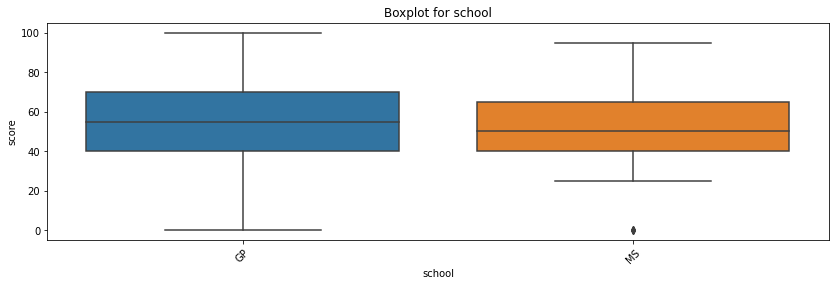

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sex     395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


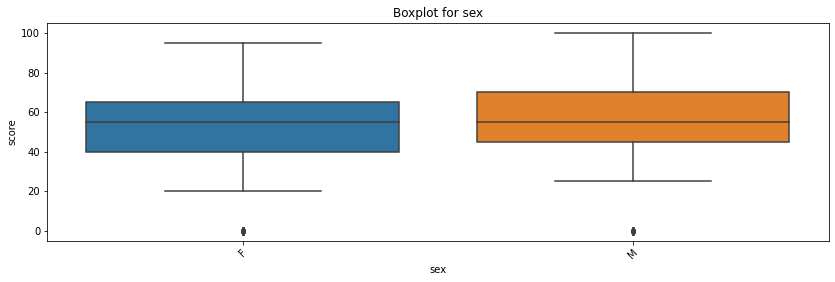

<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-11-430af630c65c>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     395 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB
25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].
Минимальное значение: 15.0
Максимальное значение: 22.0
8


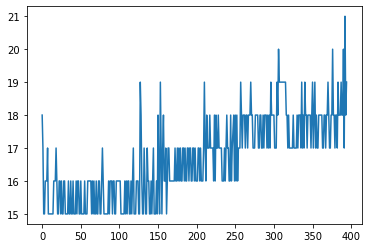

25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].


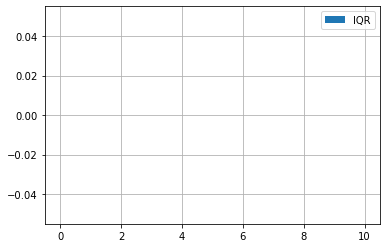

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  378 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


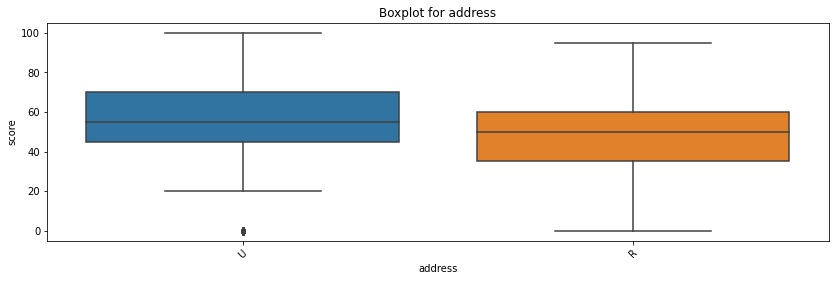

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   famsize  368 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


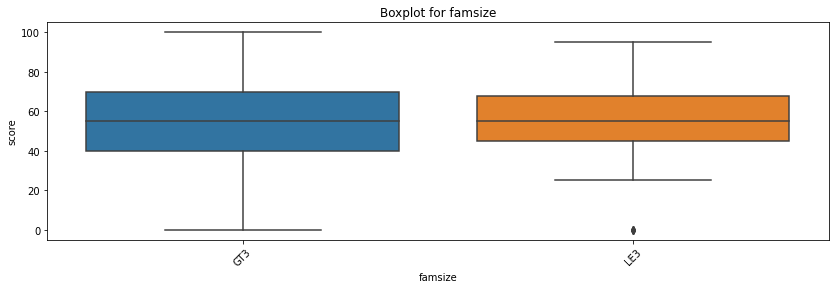

<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pstatus  350 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


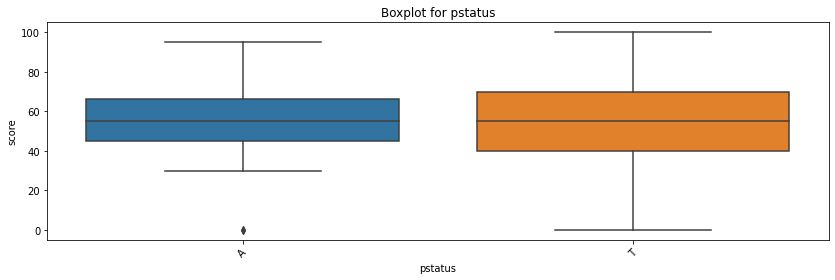

<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-11-430af630c65c>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   medu    392 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB
25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].
Минимальное значение: 0.0
Максимальное значение: 4.0
5


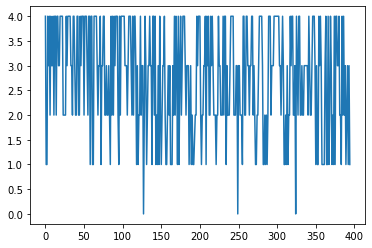

25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].


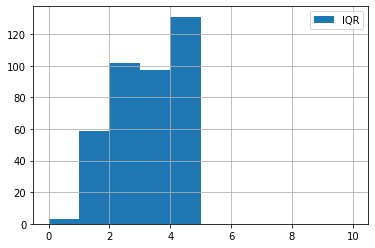

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fedu    370 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB
25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0,  Границы выбросов: [0.5, 4.5].
Минимальное значение: 0.0
Максимальное значение: 4.0
5


<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-11-430af630c65c>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


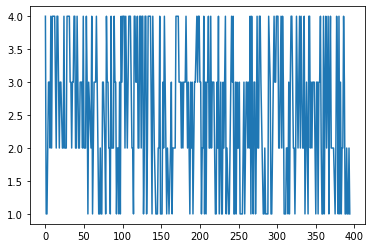

25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0,  Границы выбросов: [0.5, 4.5].


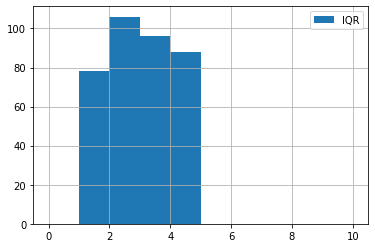

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   mjob    376 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


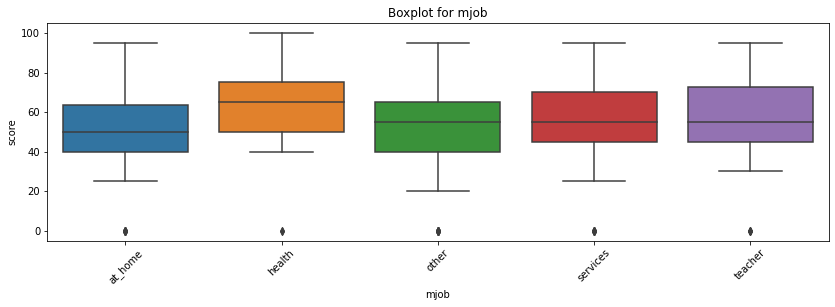

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   fjob    359 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


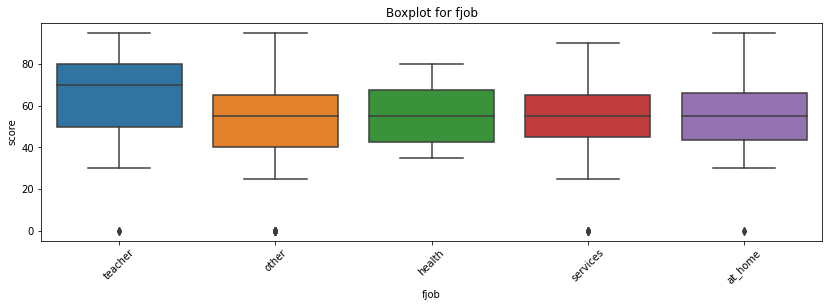

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   reason  378 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


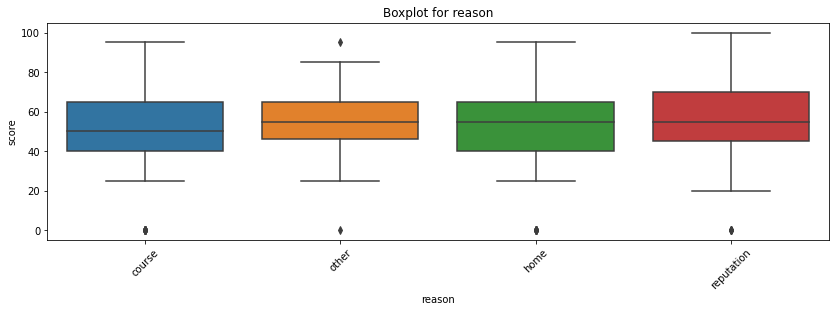

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   guardian  364 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


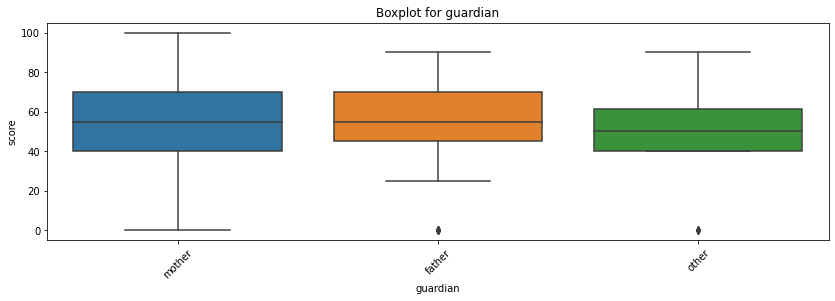

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   traveltime  367 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB
25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].
Минимальное значение: 1.0
Максимальное значение: 4.0
4


<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-11-430af630c65c>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


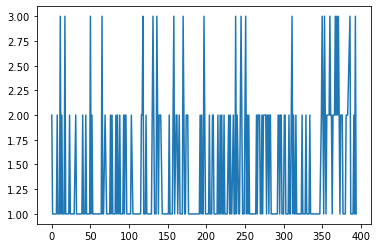

25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].


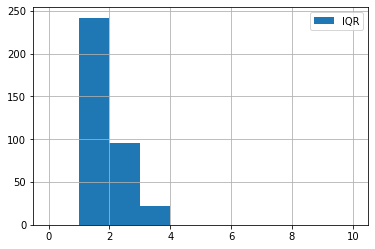

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   studytime  388 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB
25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].
Минимальное значение: 1.0
Максимальное значение: 4.0
4


<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-11-430af630c65c>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


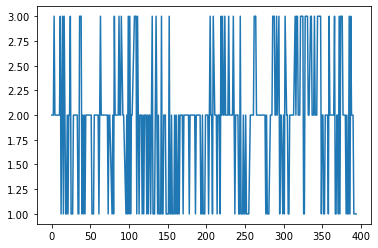

25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].


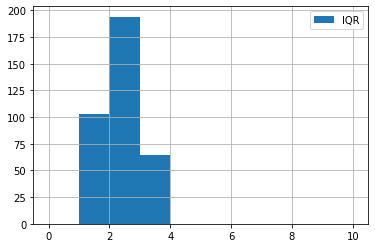

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   failures  80 non-null     float64
dtypes: float64(1)
memory usage: 3.2 KB
25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].
Минимальное значение: 1.0
Максимальное значение: 3.0
3


<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-11-430af630c65c>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


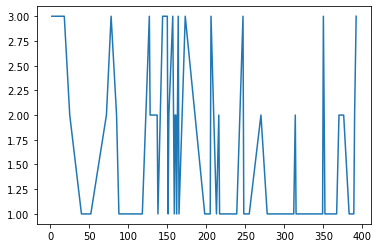

25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].


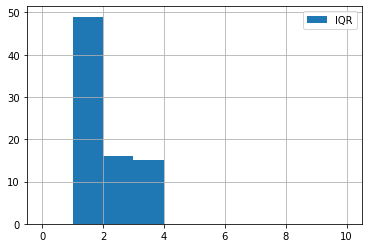

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   schoolsup  386 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


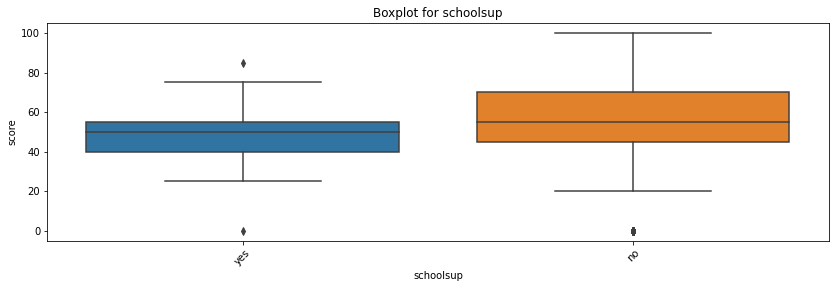

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   famsup  356 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


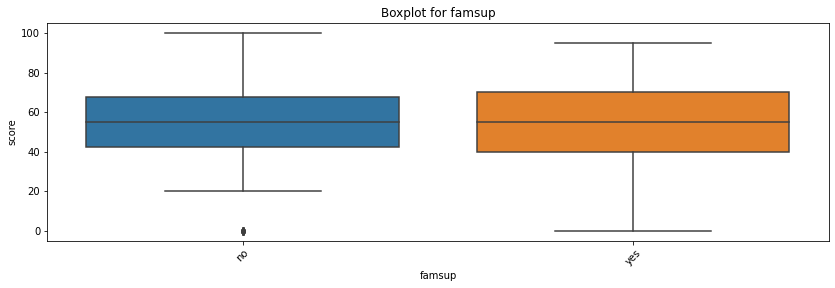

<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   paid    355 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


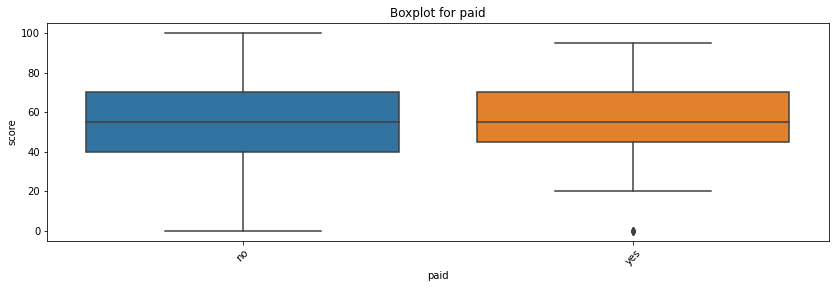

<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   activities  381 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


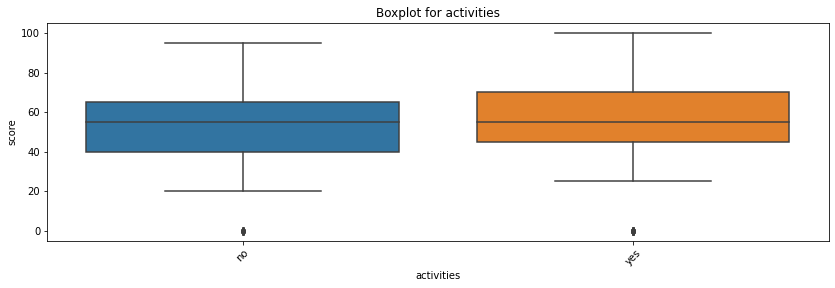

<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nursery  379 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


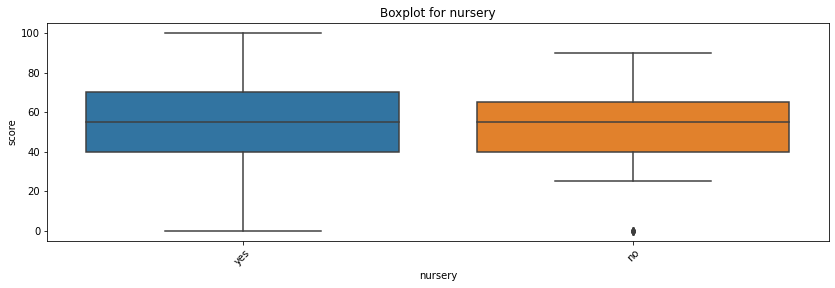

<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-11-430af630c65c>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   studytime_granular  388 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB
25-й перцентиль: -6.0, 75-й перцентиль: -3.0, IQR: 3.0,  Границы выбросов: [-10.5, 1.5].
Минимальное значение: -12.0
Максимальное значение: -3.0
4


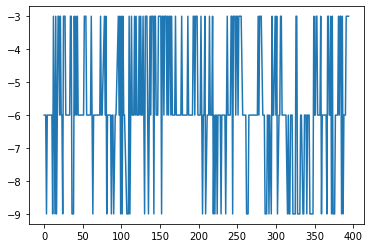

25-й перцентиль: -6.0, 75-й перцентиль: -3.0, IQR: 3.0,  Границы выбросов: [-10.5, 1.5].


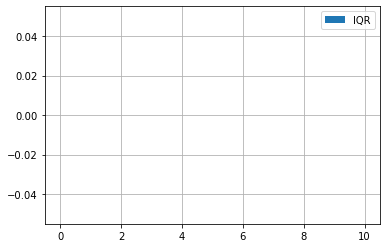

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   higher  375 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


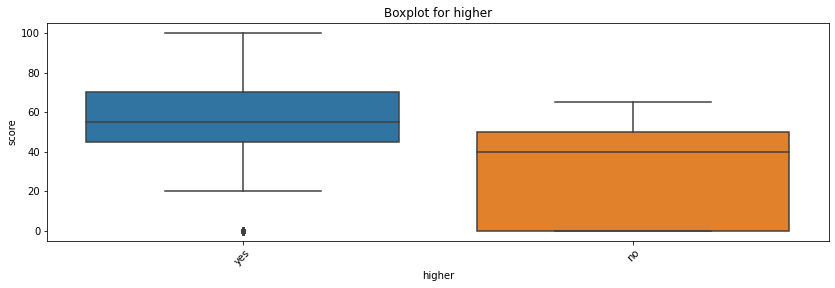

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   internet  361 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


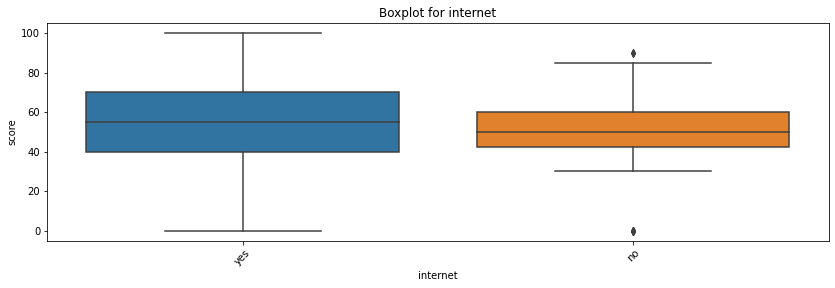

<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   romantic  364 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


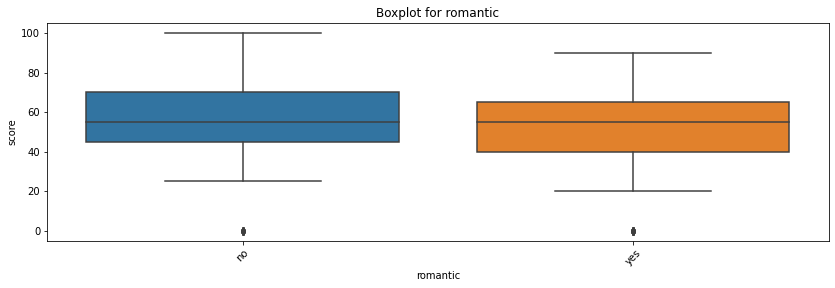

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   famrel  86 non-null     float64
dtypes: float64(1)
memory usage: 3.2 KB
25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0,  Границы выбросов: [0.5, 4.5].
Минимальное значение: 1.0
Максимальное значение: 3.0
3


<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-11-430af630c65c>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


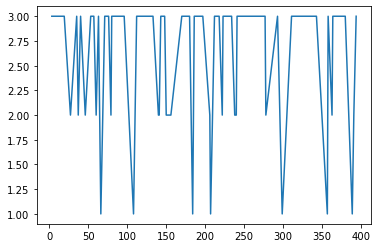

25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0,  Границы выбросов: [0.5, 4.5].


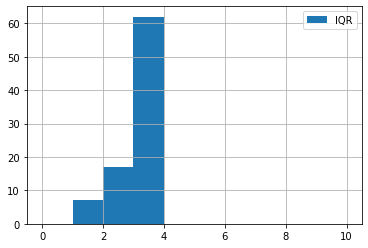

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   freetime  384 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB
25-й перцентиль: 3.0, 75-й перцентиль: 4.0, IQR: 1.0,  Границы выбросов: [1.5, 5.5].
Минимальное значение: 1.0
Максимальное значение: 5.0
5


<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-11-430af630c65c>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


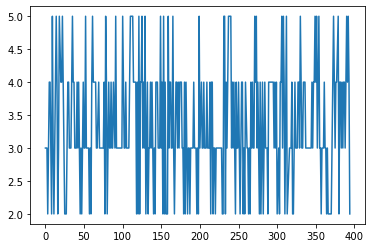

25-й перцентиль: 3.0, 75-й перцентиль: 4.0, IQR: 1.0,  Границы выбросов: [1.5, 5.5].


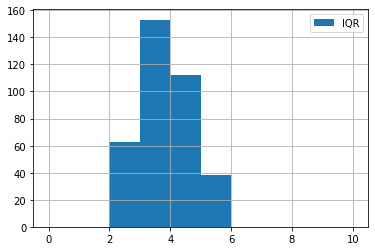

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   goout   387 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB
25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].
Минимальное значение: 1.0
Максимальное значение: 5.0
5


<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-11-430af630c65c>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


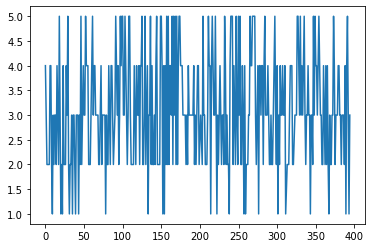

25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].


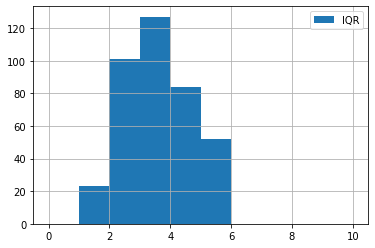

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   health  380 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB
25-й перцентиль: 3.0, 75-й перцентиль: 5.0, IQR: 2.0,  Границы выбросов: [0.0, 8.0].
Минимальное значение: 1.0
Максимальное значение: 5.0
5


<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-11-430af630c65c>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


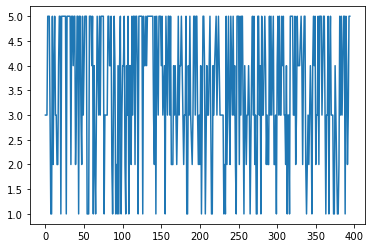

25-й перцентиль: 3.0, 75-й перцентиль: 5.0, IQR: 2.0,  Границы выбросов: [0.0, 8.0].


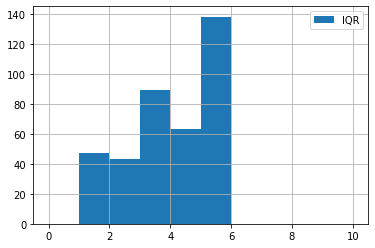

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   absences  366 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):


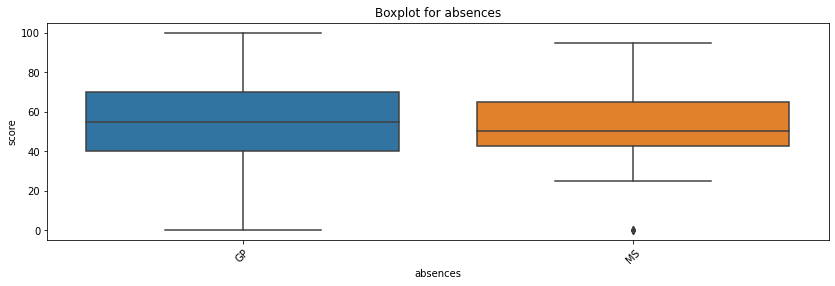

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   score   389 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB
25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].
Минимальное значение: 0.0
Максимальное значение: 100.0
18


<ipython-input-11-430af630c65c>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-11-430af630c65c>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


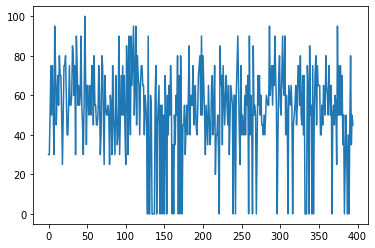

25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].


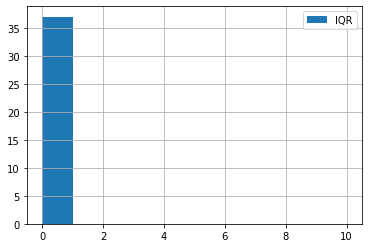

In [17]:
for col in data.columns:
    get_info(data, col)

In [146]:
data

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18.0,U,None,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,NaN,yes,no,no,no,yes,-6.0,yes,None,no,NaN,3.0,4.0,3.0,GP,30.0
1,GP,F,17.0,U,GT3,None,1.0,1.0,at_home,other,course,father,1.0,2.0,NaN,no,yes,no,no,no,-6.0,yes,yes,no,NaN,3.0,3.0,3.0,GP,30.0
2,GP,F,15.0,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,None,no,yes,-6.0,yes,yes,None,NaN,3.0,2.0,3.0,GP,50.0
3,GP,F,15.0,U,GT3,T,4.0,2.0,health,None,home,mother,1.0,3.0,NaN,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,GP,75.0
4,GP,F,16.0,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,NaN,no,yes,yes,no,yes,-6.0,yes,no,no,NaN,3.0,2.0,5.0,GP,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20.0,U,LE3,A,2.0,2.0,services,services,course,None,1.0,2.0,2.0,no,yes,yes,no,yes,-6.0,yes,no,no,NaN,5.0,4.0,4.0,NaN,45.0
391,MS,M,17.0,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,NaN,no,no,no,no,no,-3.0,yes,yes,no,2.0,4.0,5.0,2.0,MS,80.0
392,MS,M,21.0,R,GT3,T,1.0,1.0,other,other,course,None,1.0,1.0,3.0,None,no,no,no,no,-3.0,None,no,no,NaN,5.0,3.0,3.0,MS,35.0
393,MS,M,18.0,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,NaN,no,no,no,None,no,-3.0,yes,yes,no,NaN,4.0,1.0,5.0,MS,50.0


In [18]:
#columnsForDrop=['sex','famsize', 'pstatus', 'reason', 'famsup']
#for col in columnsForDrop:
#    data.drop([col], inplace = True, axis = 1)

In [19]:
df_subset=data
for col in df_subset.columns[0:len(df_subset.columns)-1]:
        get_stat_dif(df_subset, col)

Найдены статистически значимые различия для колонки mjob


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeW

4


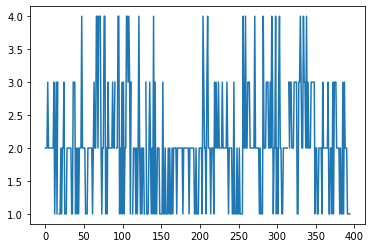

In [130]:
print(data.studytime.nunique())
plt.plot(data.studytime)

In [131]:
data.studytime.value_counts()

2.0    194
1.0    103
3.0     64
4.0     27
Name: studytime, dtype: int64

25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].


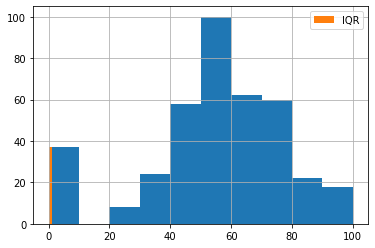

In [132]:
data.score.hist()
plot_hist(data,'score')


<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


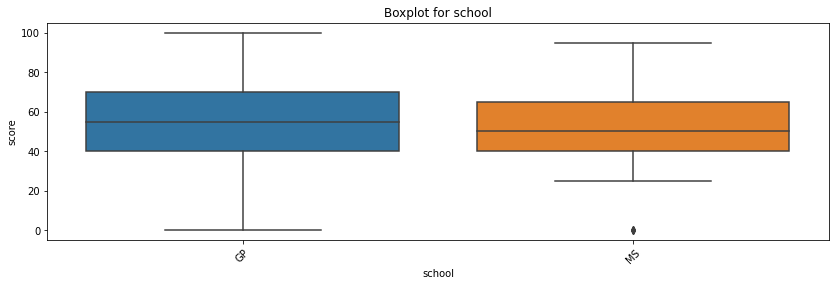

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


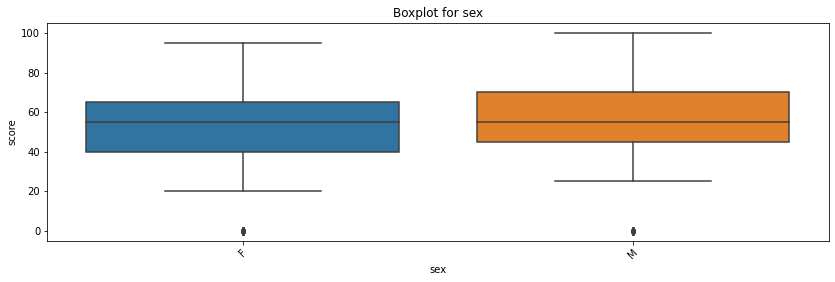

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


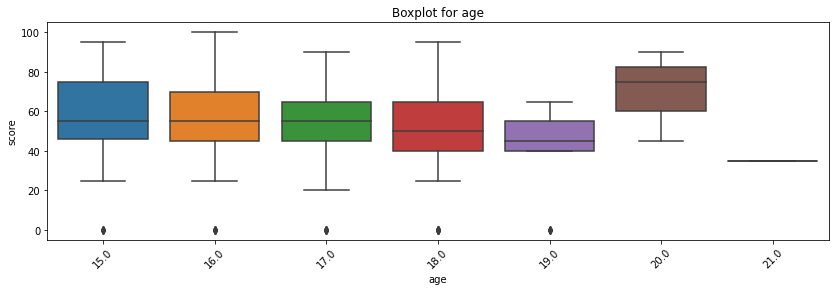

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


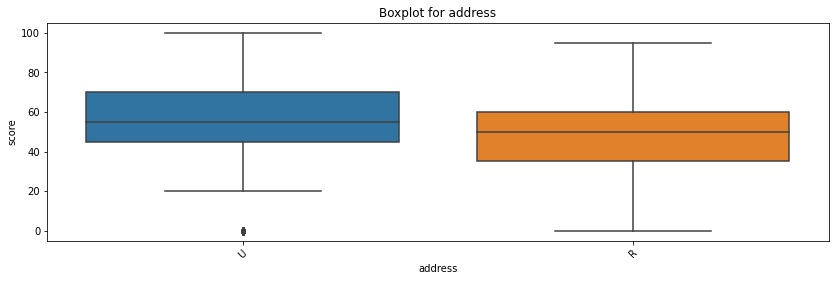

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


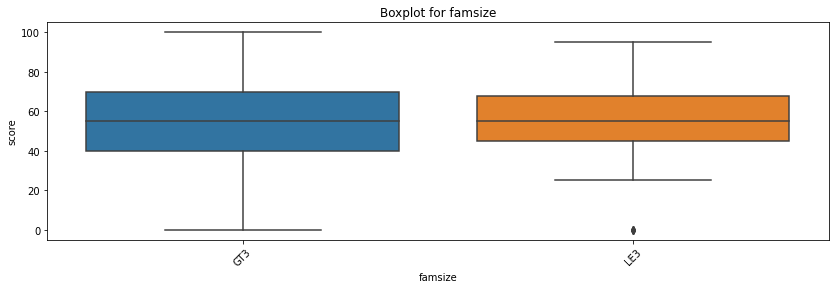

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


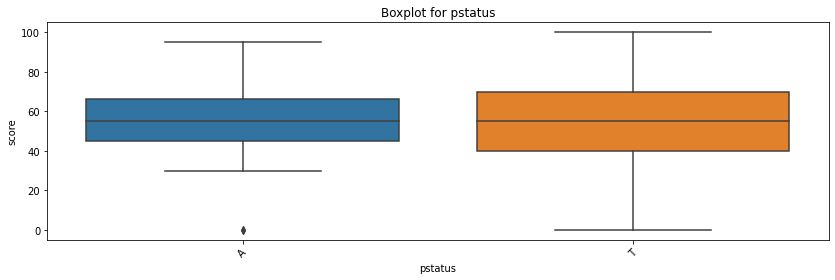

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


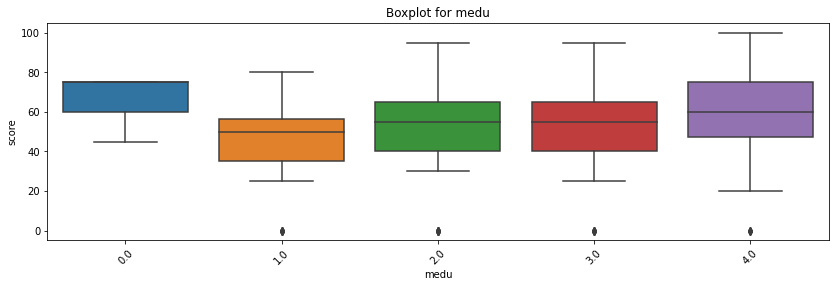

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


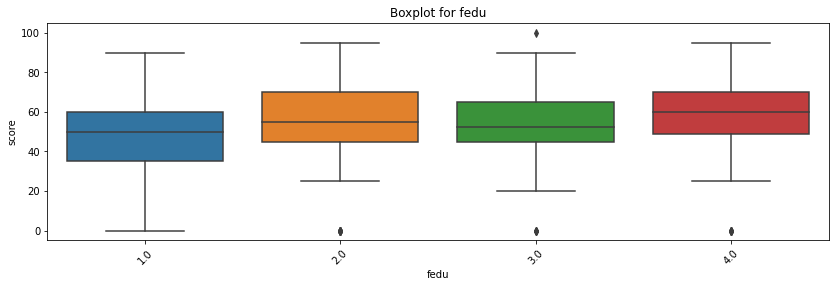

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


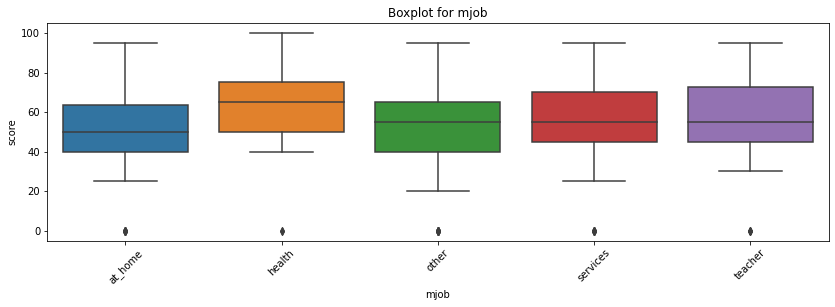

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


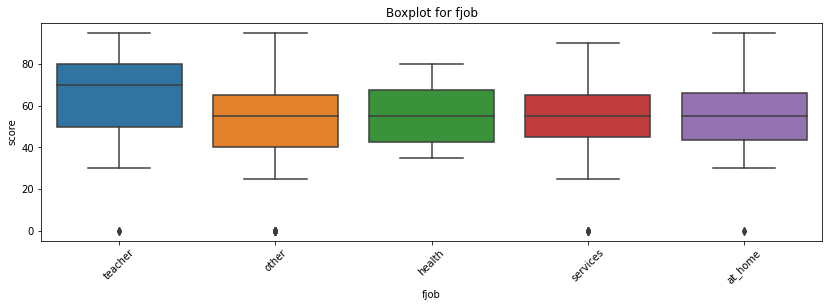

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


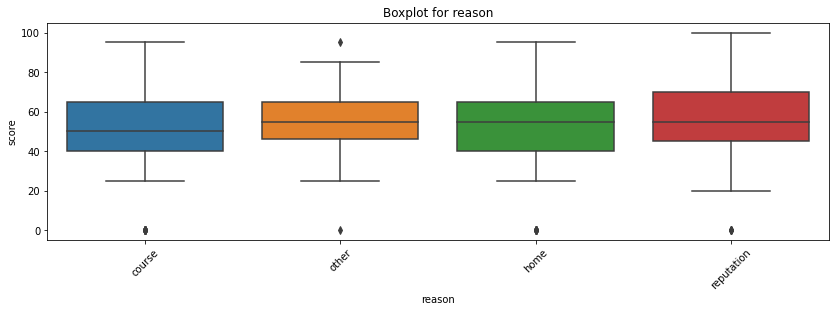

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


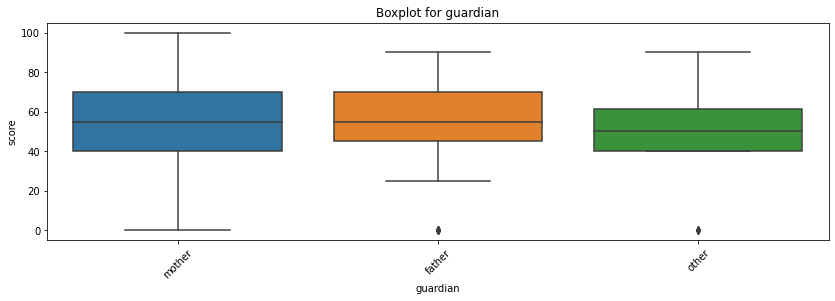

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


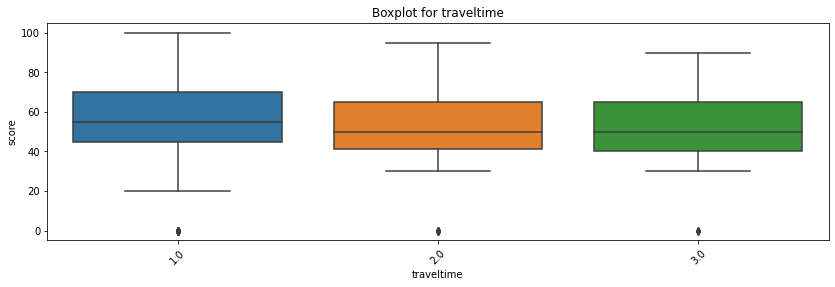

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


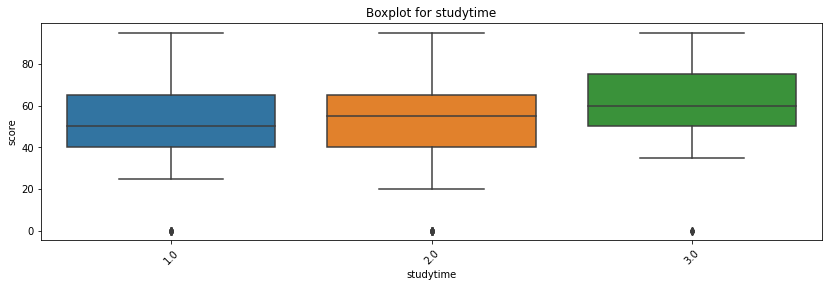

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


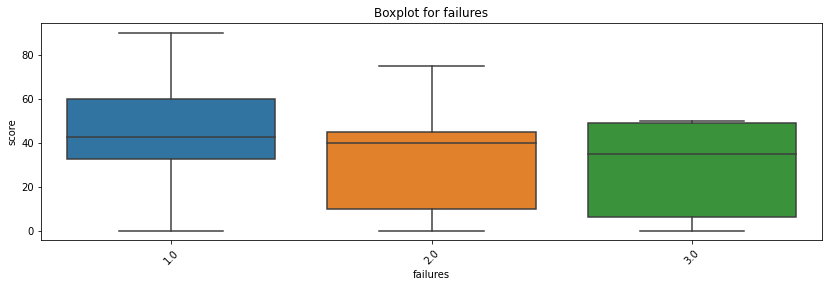

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


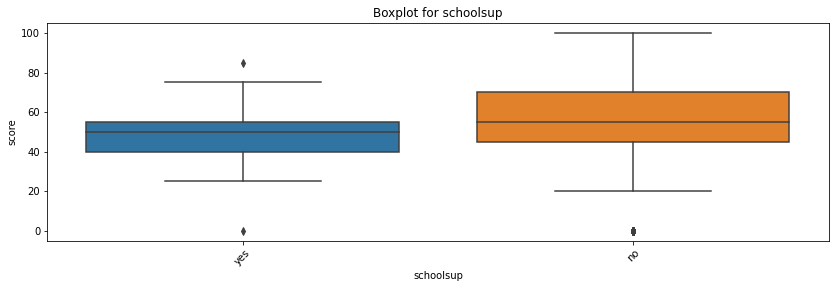

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


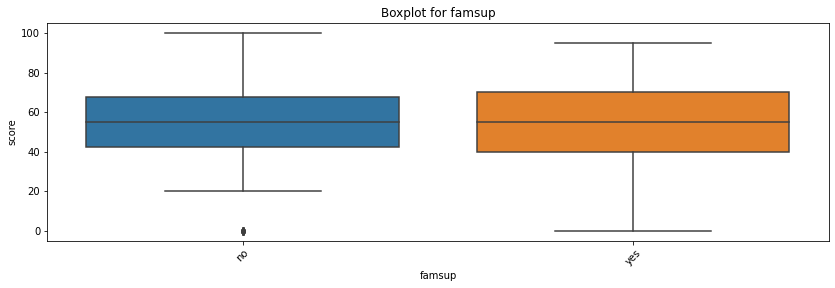

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


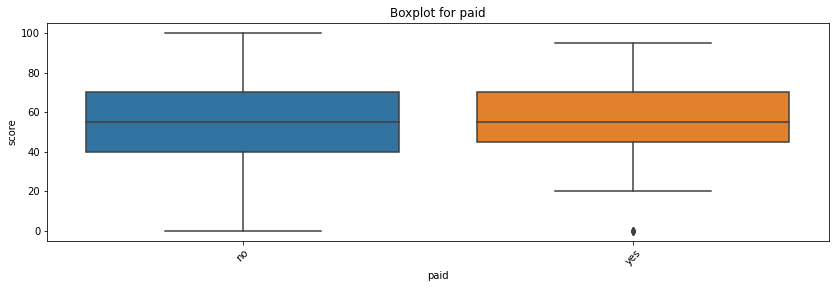

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


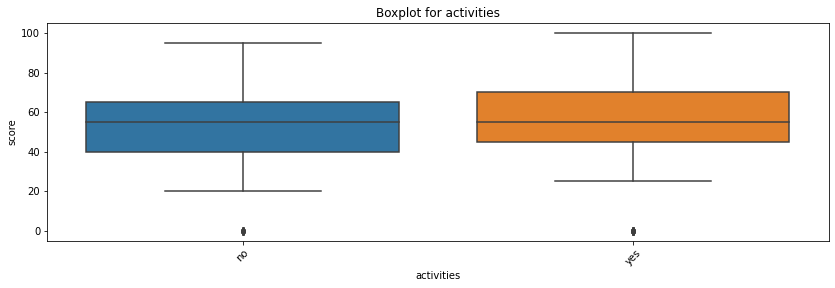

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


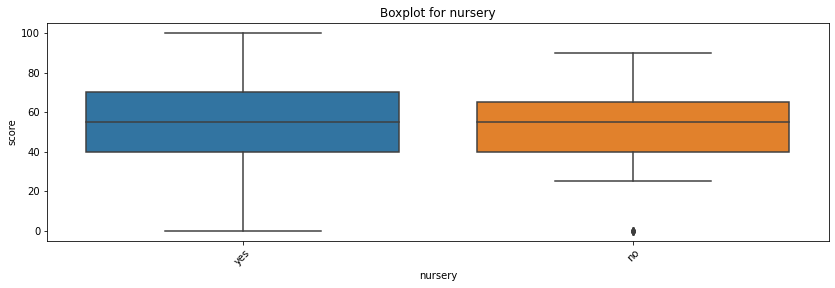

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


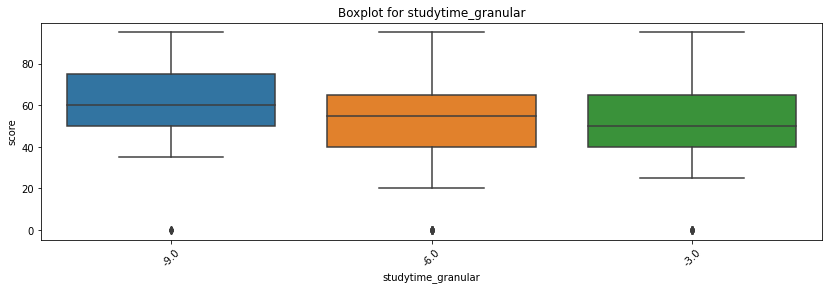

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


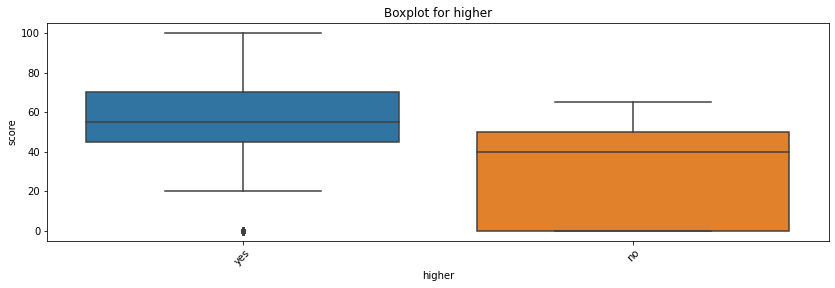

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


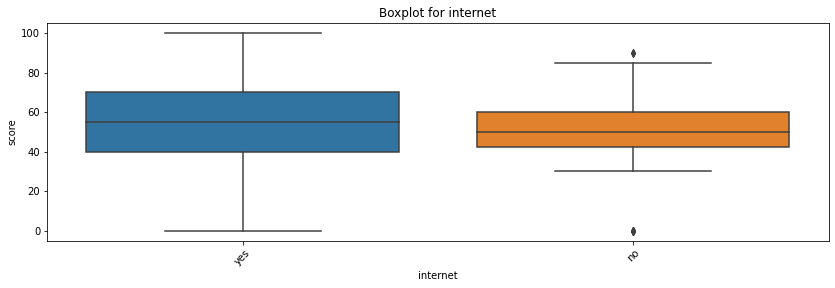

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


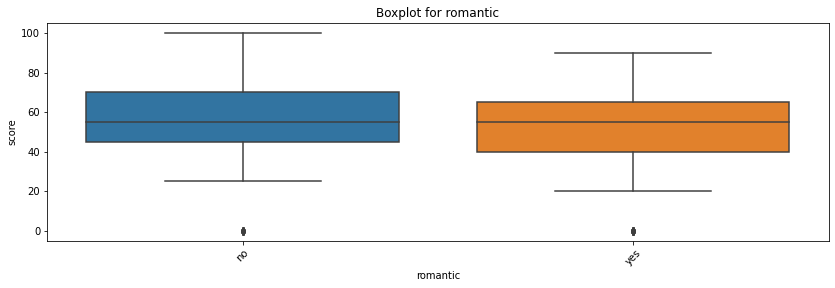

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


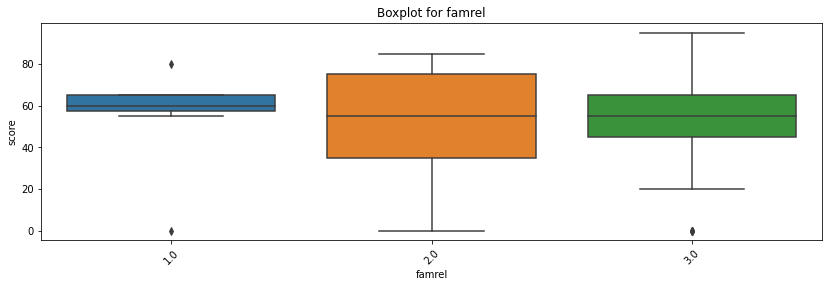

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


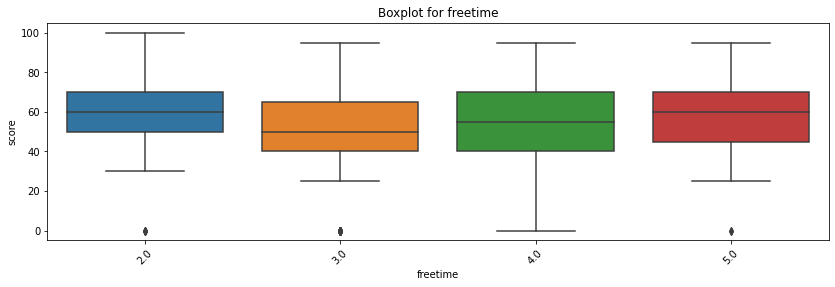

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


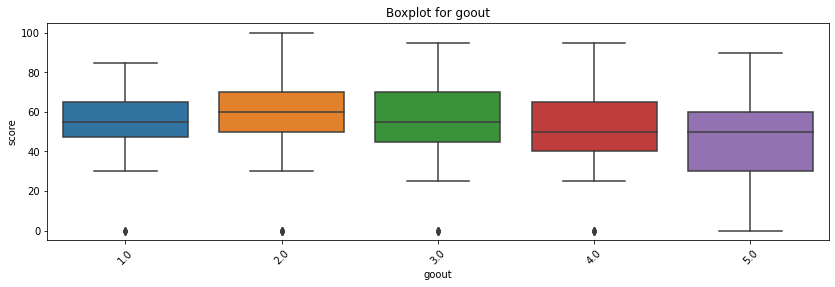

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


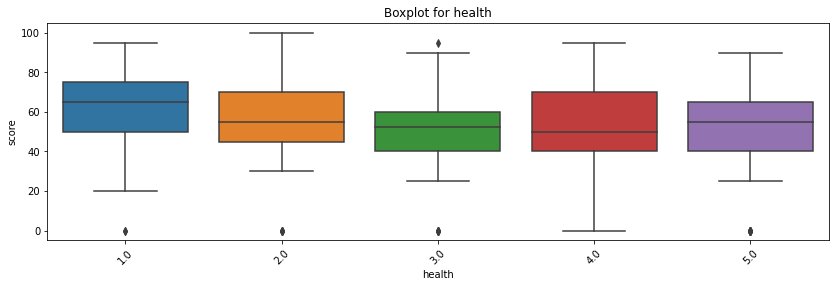

<ipython-input-91-c082ffdbe866>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


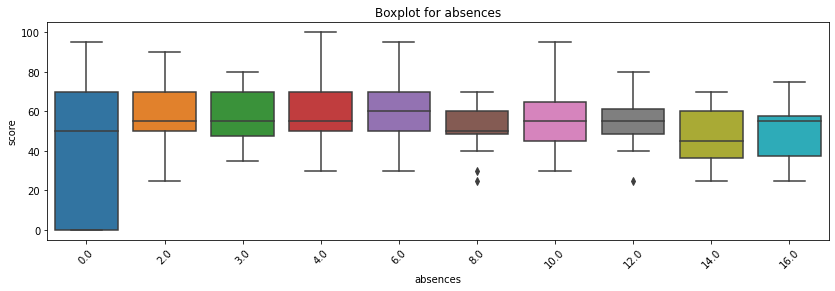

In [104]:
#df_subset = data.select_dtypes(include=[np.number])
    
for col in df_subset.columns[0:len(df_subset.columns)-1]:
    get_boxplot(check_over_limits(df_subset, col),col,'score' )
    #df_subset[col]=check_over_limits(df_subset, col)

In [149]:
display(clear_frame(df_subset).corr())

,age,medu,fedu,traveltime,studytime,failures,studytime_granular,famrel,freetime,goout,health,score
age,1.000000,-0.167883,-0.162747,0.115437,0.070557,-0.116152,-0.070557,0.009471,0.030180,0.119997,-0.047402,-0.153518
medu,-0.167883,1.000000,0.639999,-0.135171,0.091193,-0.150980,-0.091193,-0.190743,0.012817,0.064164,-0.045051,0.213349
fedu,-0.162747,0.639999,1.000000,-0.094873,0.089786,-0.290966,-0.089786,-0.112713,-0.040852,0.040199,0.008538,0.139615
traveltime,0.115437,-0.135171,-0.094873,1.000000,-0.128818,-0.094095,0.128818,0.052670,-0.062865,-0.033557,-0.035184,-0.072792
studytime,0.070557,0.091193,0.089786,-0.128818,1.000000,-0.168699,-1.000000,-0.029175,-0.089910,-0.047142,-0.042698,0.112830
failures,-0.116152,-0.150980,-0.290966,-0.094095,-0.168699,1.000000,0.168699,-0.026207,-0.016850,0.125683,-0.110240,-0.184783
studytime_granular,-0.070557,-0.091193,-0.089786,0.128818,-1.000000,0.168699,1.000000,0.029175,0.089910,0.047142,0.042698,-0.112830
famrel,0.009471,-0.190743,-0.112713,0.052670,-0.029175,-0.026207,0.029175,1.000000,0.039112,-0.048018,0.178664,-0.006995
freetime,0.030180,0.012817,-0.040852,-0.062865,-0.089910,-0.016850,0.089910,0.039112,1.000000,0.258559,0.056916,0.000582
goout,0.119997,0.064164,0.040199,-0.033557,-0.047142,0.125683,0.047142,-0.048018,0.258559,1.000000,-0.015608,-0.129685


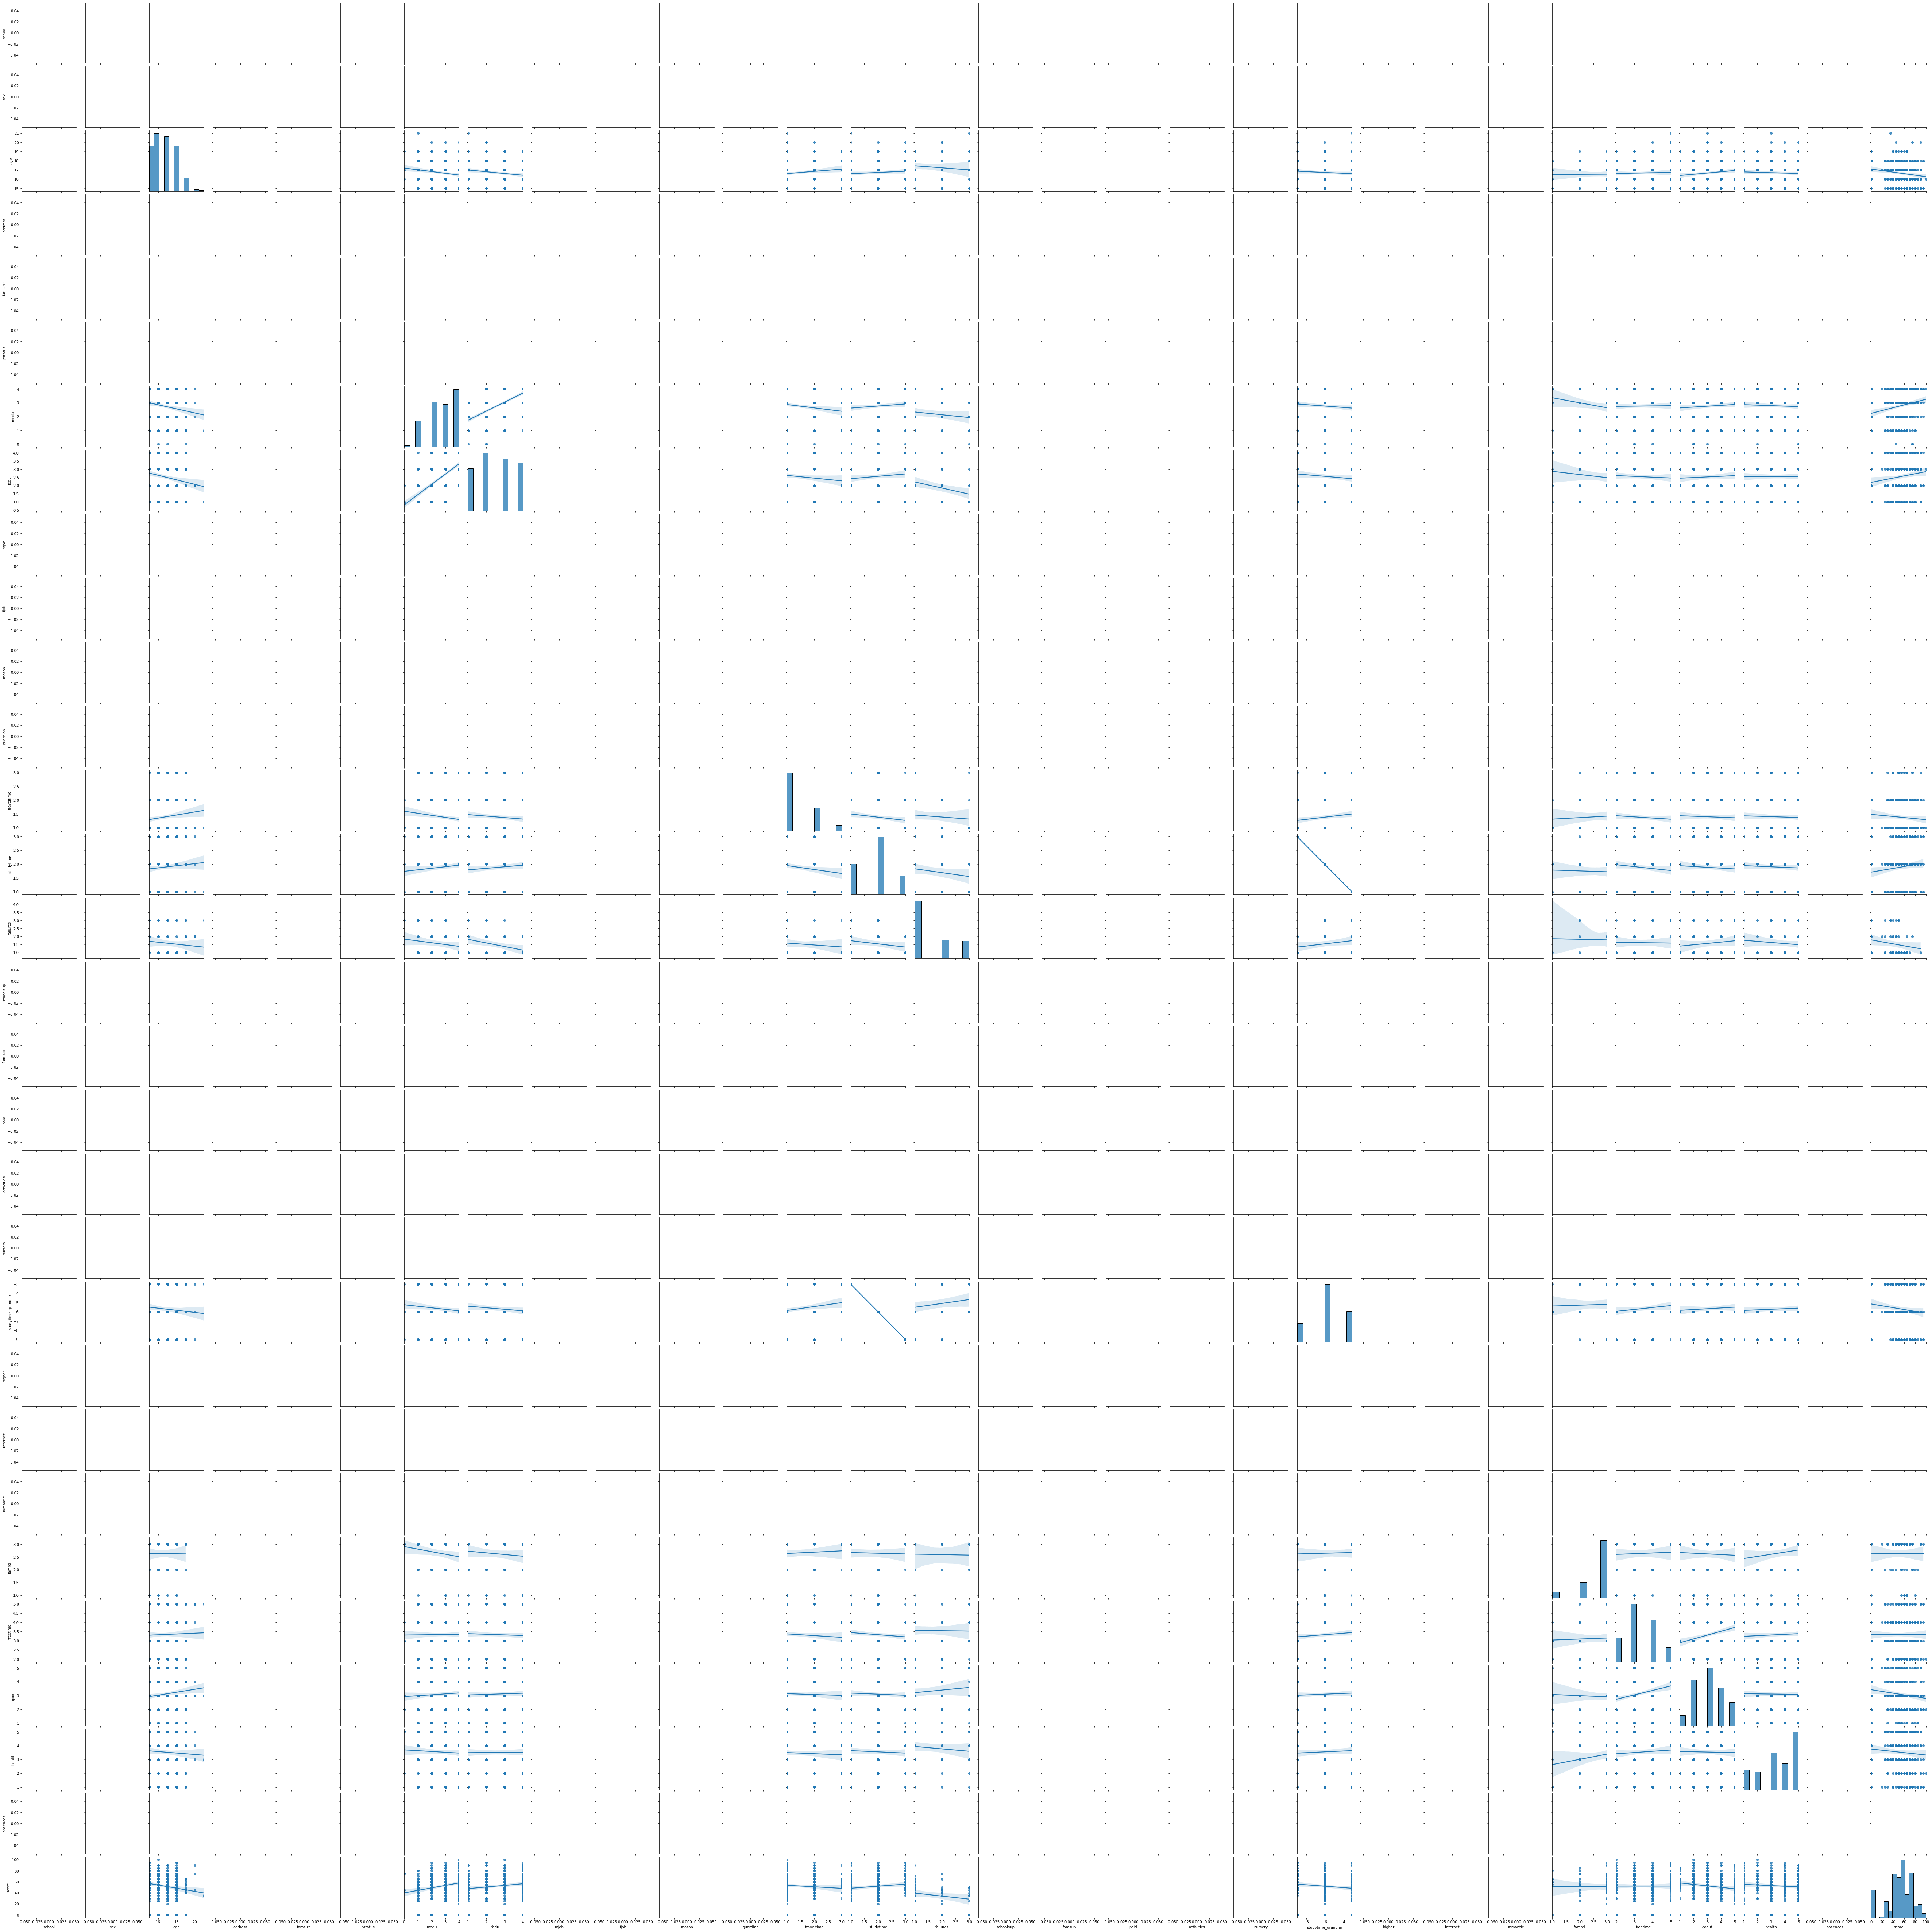

In [156]:
sns.pairplot(clear_frame(df_subset), kind = 'reg')

In [150]:
for col in df_subset.columns[0:len(df_subset.columns)-1]:
        get_stat_dif(df_subset, col, 'score')

Найдены статистически значимые различия для колонки mjob


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeW